![scientisst-notebooks_top-banner](https://raw.githubusercontent.com/scientisst/notebooks/59632d3d477981a3b1cc12157e12bbdcdb45def8/_Resources/top-banner.png)

# <span style='color:#484848;'> Clustering of Human Activity Data </span>

### <span style='color:#00aba1;'> Keywords </span>

`Clustering`, `Unsupervised Learning`, `Accelerometry Data`

### <span style='color:#00aba1;'> Notebook Info </span>

**Contributors(s):** Mariana Abreu, Patrícia Bota, Ana Fred

**Date of creation:** 2020

**Last update:** 2021

<p align="center">
<img src="./_Resources/arm-raise-new.png" width="500"/> 
</p>
<p style="color:#484848;text-align:center"> <i> Illustration of human activity data as a moto for usupervised learning. </i> </p>

### <span style="color:#00aba1;"> Description & Objectives </span>
In the previous lab, accelerometer signals were split into segments corresponding to repetitions of the 4 activities performed in Lab1. In this lab we will process and analyse individual segments gathered from recordings from 6 users. In the end of this activity you should have:

* Learn to segment motion signals
* Extract meaningful information from accelerometer
* Perform activity recognition through simple clustering

# <span style="color:#00aba1;"> 1. Introduction </span>


## <span style="color:#484848;"> Unsupervised Learning </span>

Unsupervised learning is better explained in comparison with its supervised conterpart. As illustrated in Figure 1, this machine learning technique attempts to create groups from data without knowing what their actual _labels_ are.

Instead, it attempts to group data in **clusters** in a way that maximizes similarity between data points within the same cluster while minimizing similarity between data points within different clusters. 

<p align="center">
<img src="./_Resources/supervised_vs_unsupervised.png" width="600"/> 
</p>
<p style="color:#484848;text-align:center"> <i> Figure 1: Supervised vs unsupervised learning. </i> </p>

In a way, different clustering techniques are just different ways of measuring these (dis)similarities.

# <span style="color:#00aba1;"> 2. Hands-On </span>

## <span style="color:#484848;"> 2.1. Requirements </span>
The following libraries are required, and should be installed using the command:

In [19]:
!pip install sklearn >/dev/null 2>&1
!pip install scipy >/dev/null 2>&1
!pip install pandas >/dev/null 2>&1
!pip install mpld3 >/dev/null 2>&1
!pip install biosppy >/dev/null 2>&1
%matplotlib inline

In [20]:
import numpy as np #NumPy is the fundamental package for scientific computing with Python. 
import matplotlib.pyplot as plt #Matplotlib is a Python 2D plotting library
from pylab import *
import os
import pandas as pd
from collections import OrderedDict
from sklearn.preprocessing import minmax_scale
import scipy
import pickle
import mpld3

## <span style="color:#484848;"> 2.2. Loading the Data </span>


In [21]:
data = pickle.load(open('./_Resources/science_journal_data_user1', 'rb'))
activities_dir = list(data.keys())

## <span style="color:#484848;"> 2.3. Data Reconstruction </span>


> ⚠️ **WARNING:** The data acquired through Google Science Journal was not perfectly aquired, thus it is necessary to compute missing values. For that, we first remove all 'nan' and then the signal is reconsctructed based on the length and the existing values. On the following plots we show the comparison between the original data and reconstructed data.   

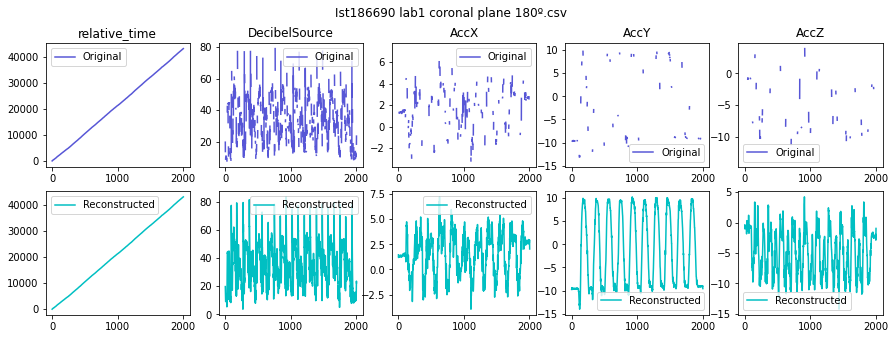

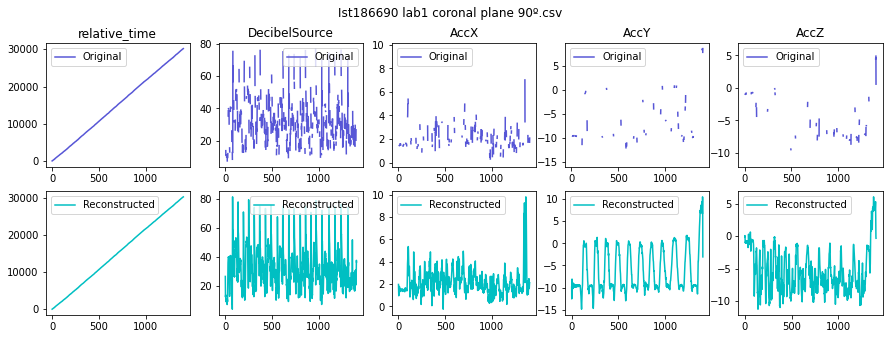

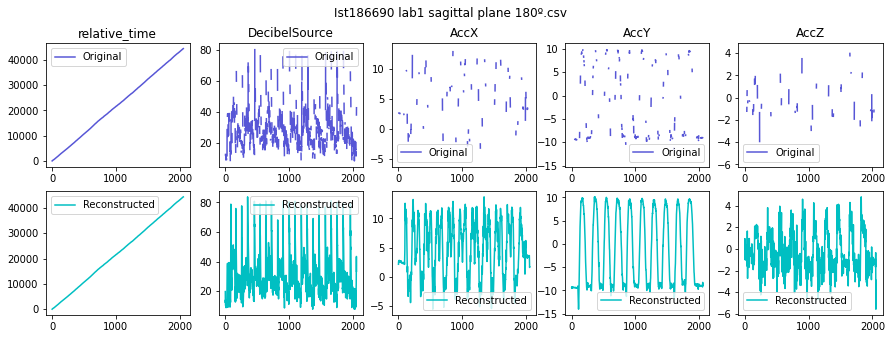

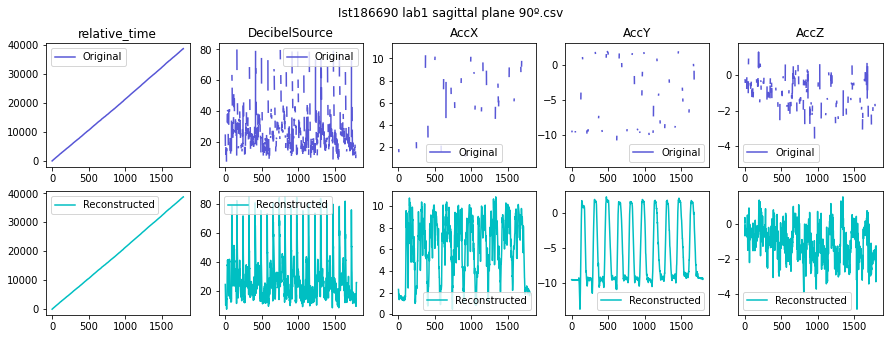

In [22]:
colors = ['#00bfc2','#5756d6','#fada5e', '#62d321', '#fe9b29']

from scipy.signal import resample
for act in activities_dir:
    a = 0
    

    plt.figure(figsize=(15,5))
    for axis in data[act].columns:
        a+=1
        plt.suptitle(act)
        plt.subplot(2,5,a+5)
        original_sig = data[act][axis].copy()
        
        data[act][axis] = resample(data[act].dropna(subset=[axis])[axis].values, len(data[act][axis]))
        plt.plot(data[act][axis], color = colors[0], label='Reconstructed')
        plt.legend()
        plt.subplot(2,5,a)
        plt.title(axis)
        plt.plot(original_sig, color = colors[1], label='Original')
        plt.legend()
    plt.show()
        

> ⚠️ **WARNING:** Since we replace the original signal by the reconstructed, you need to play the previous cell again, to read the original signal and do its reconstruction. Otherwise, both plots will show the same signal.

## <div style="color:#484848;">  2.3. Data Segmentation</div>


Only use axis 'AccX', 'AccY' and 'AccZ'. These signals will be segmented through 'AccY'. The activity starts when the axis Y reaches its minimum value and it stops when the maximum of each cycle is reached.

> ⚠️ **WARNING:** The following code might need some adjustments in the distance parameter, in order to find all peaks. If this value is too large, some peaks will not be found and to many peaks will be found if this parameter is to small. Check in the plot if all peaks are correctly found.

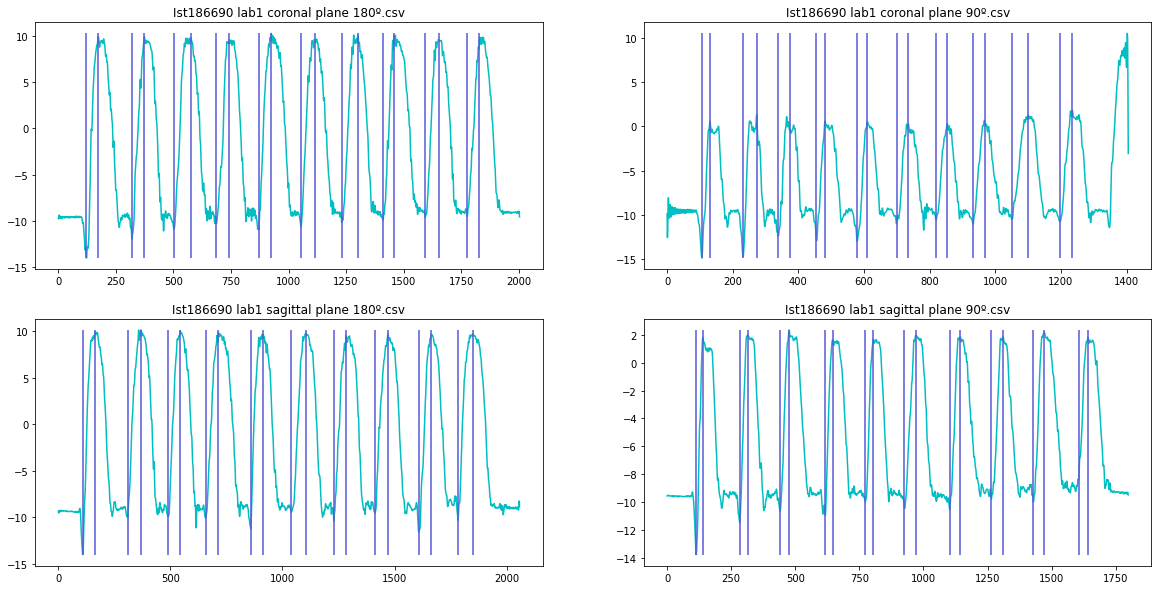

In [23]:
segment_idx = OrderedDict()
i = 1
plt.figure(figsize=(20,10))

for act in activities_dir:
    x = data[act]['AccY']
    max_points = scipy.signal.find_peaks(x, height=np.mean(x), threshold=None, distance=100, prominence=None, 
                                         width=None, wlen=None, rel_height=0.5, plateau_size=None)[0]
    min_points = scipy.signal.find_peaks(x*(-1), height=np.mean(-x), threshold=None, distance=30, prominence=None, 
                                         width=None, wlen=None, rel_height=0.5, plateau_size=None)[0]
    plt.subplot(2,2,i)
    i += 1
    plt.plot(data[act]['AccY'], color=colors[0])
    plt.title(act)
    mp_new = []
    for mx in max_points:
        min_point = min_points[np.argmin([abs(mp-mx) for mp in min_points[np.argwhere(min_points<mx)]])]
        mp_new += [min_point]
        
    
    segment_idx[act] = np.vstack([mp_new, max_points]).T
    if act == activities_dir[1]:
        segment_idx[act] = segment_idx[act][:-1]
    plt.vlines(segment_idx[act].ravel(), np.min(x), np.max(x), color=colors[1])
plt.show()


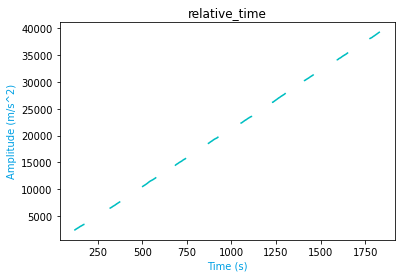

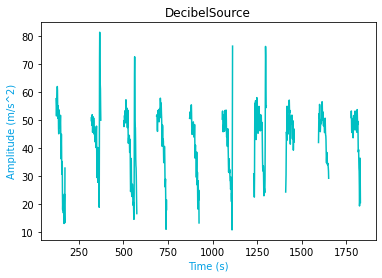

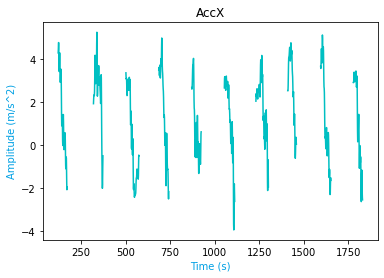

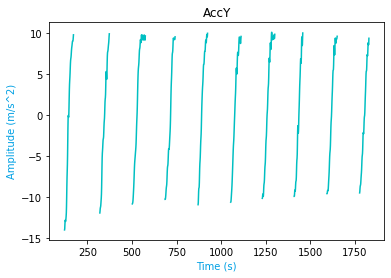

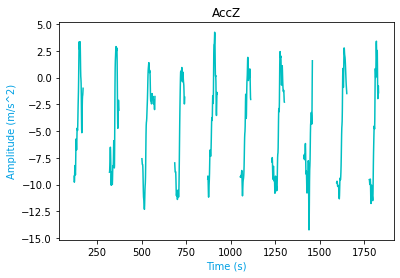

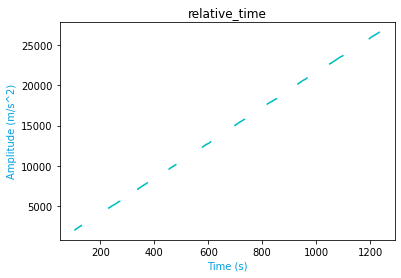

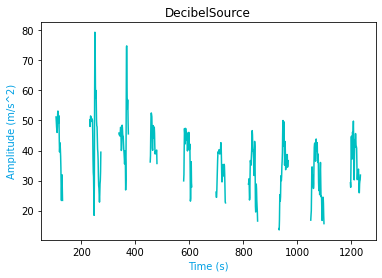

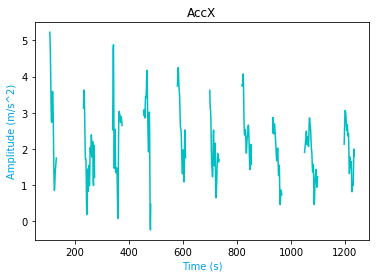

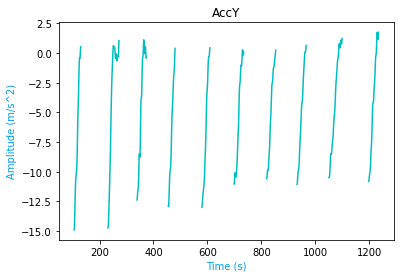

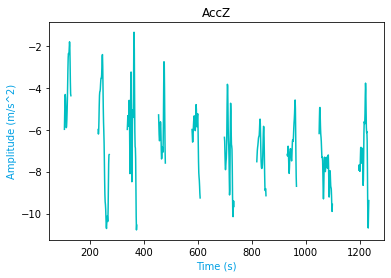

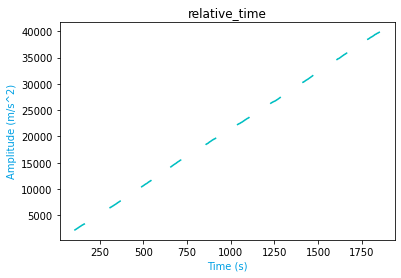

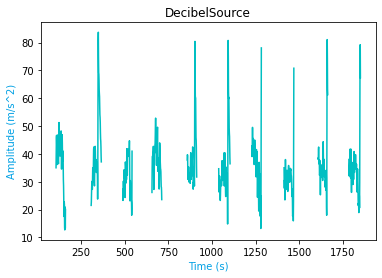

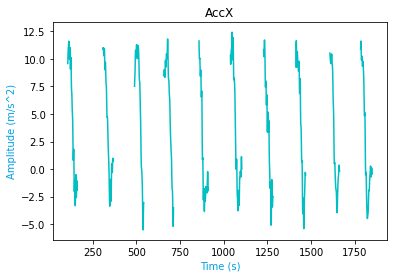

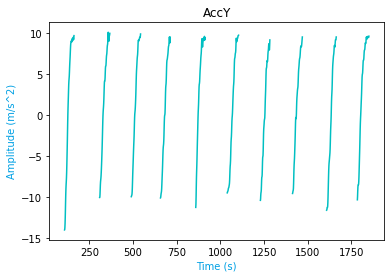

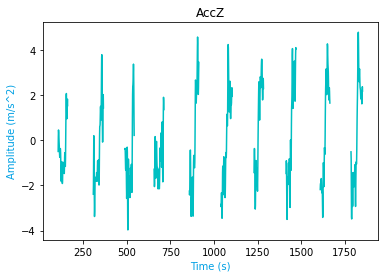

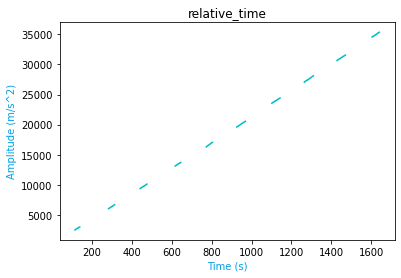

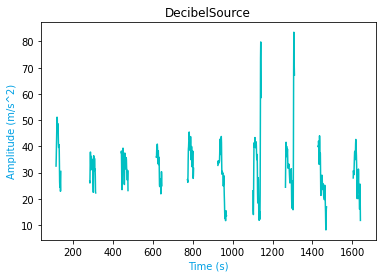

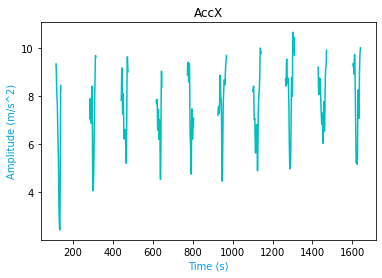

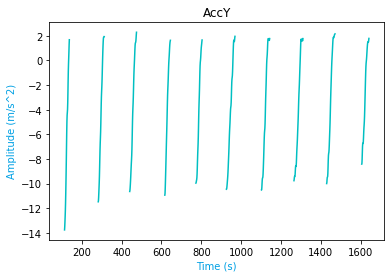

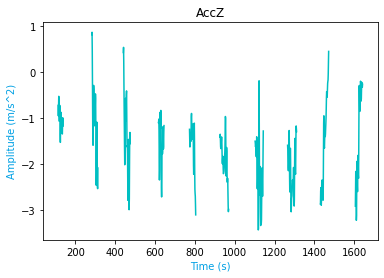

In [24]:

segmented_data = OrderedDict()
for act in activities_dir:
    segmented_data[act] = pd.DataFrame()
    for axis in data[act].columns:
        segments = []
        for sidx in segment_idx[act]:
            
            segments  += [data[act][axis][sidx[0]:sidx[1]]]
            
            plt.plot(segments[-1], color=colors[0])
            plt.xlabel('Time (s)', color="#00a0e4")
            plt.ylabel('Amplitude (m/s^2)', color="#00a0e4")
        plt.title(axis)
        plt.show()
        
        segmented_data[act][axis] = segments
            

## <div style="color:#484848;">   2.4. Feature Engineering</div>


In [25]:
feats_data = OrderedDict()
feats = ['mean', 'median', 'min', 'max', 'max_amp', 'var', 'std_dev', 'abs_dev', 'kurtosis', 'skewness']

import biosppy as bs
for act in activities_dir:
    for axis in ['AccX', 'AccY', 'AccZ']:
        feats_val = []
        feats_axis = [axis +'-'+ ft for ft in feats]
        for seg in range(len(segmented_data[act][axis])):
            feats_val += [bs.signals.tools.signal_stats(segmented_data[act][axis][seg])]
        if axis == 'AccX':
            new_row = pd.DataFrame(feats_val, columns = feats_axis)
        else:
            new_row = pd.concat([new_row, pd.DataFrame(feats_val, 
                                                            columns=[axis +'-'+ ft for ft in feats])], axis=1)
    feats_data[act] = new_row

> 📋 **NOTE:** Even though we have five columns, we chose to use only AccX, AccY and AccZ. While column relative_time is not informative, column DecibelSource has wrong information, since the activities performed are not sound dependent, sound was used as a marker for segmentation. Still it was more reliable to segment through the well defined AccY, than through sound.

In [26]:
print('Features for activity ', act)
feats_data[activities_dir[1]]

Features for activity  Ist186690 lab1 sagittal plane 90º.csv


,AccX-mean,AccX-median,AccX-min,AccX-max,AccX-max_amp,AccX-var,AccX-std_dev,AccX-abs_dev,AccX-kurtosis,AccX-skewness,...,AccZ-mean,AccZ-median,AccZ-min,AccZ-max,AccZ-max_amp,AccZ-var,AccZ-std_dev,AccZ-abs_dev,AccZ-kurtosis,AccZ-skewness
0,2.650278,2.736431,0.850089,5.227230,2.576953,1.742346,1.319979,1.099475,-0.900072,0.364655,...,-3.991720,-4.316609,-5.978335,-1.801910,2.189810,1.918970,1.385269,1.162446,-1.392887,0.171473
1,1.760138,1.734273,0.181866,3.630531,1.870393,0.631056,0.794390,0.592237,0.373107,0.594108,...,-6.630799,-6.143796,-10.714427,-2.409690,4.221109,7.641360,2.764301,2.413007,-1.474985,-0.103019
2,2.305423,2.537056,0.074440,4.881927,2.576503,1.153367,1.073949,0.828922,0.394063,0.137135,...,-5.998942,-5.797249,-10.782236,-1.343874,4.783293,4.758095,2.181306,1.601324,0.265251,-0.231439
3,2.642945,2.949048,-0.240397,4.172633,2.883342,1.335713,1.155731,0.799590,1.062622,-1.231939,...,-5.971324,-6.276714,-7.588180,-2.752803,3.218521,1.734962,1.317180,0.953742,1.007047,1.250257
4,2.556192,2.452241,1.085793,4.248636,1.692443,0.992374,0.996180,0.829013,-1.216182,0.302371,...,-6.350037,-5.858841,-9.254594,-4.799546,2.904557,1.608529,1.268278,0.908198,0.060496,-1.118360
5,1.839624,1.717188,0.648848,3.619572,1.779948,0.483327,0.695217,0.502364,0.445924,0.739317,...,-7.123438,-7.040036,-10.149444,-3.829819,3.293619,2.845340,1.686813,1.325076,-0.541487,0.027944
6,2.495903,2.382639,1.431247,4.073526,1.577622,0.541239,0.735689,0.527549,0.003319,0.889820,...,-7.079031,-6.974526,-9.148206,-5.491858,2.069175,1.046192,1.022835,0.841882,-0.733727,-0.436268
7,1.738818,1.761125,0.458508,2.867506,1.280310,0.544979,0.738227,0.620393,-1.206415,-0.201127,...,-6.778445,-6.935505,-8.698413,-4.579134,2.199311,0.947179,0.973231,0.718720,0.090080,0.547521
8,1.811964,1.969845,0.460348,2.855937,1.351616,0.405694,0.636941,0.539748,-0.931728,-0.285632,...,-7.694821,-7.687965,-9.898939,-4.935294,2.759527,1.406951,1.186150,0.902617,0.007795,0.436978
9,1.979769,1.897474,0.813960,3.064339,1.165809,0.473191,0.687889,0.605703,-1.274655,-0.028248,...,-7.167347,-7.263694,-10.691067,-3.774043,3.523720,2.718658,1.648835,1.248400,0.064204,-0.104554


## <div style="color:#484848;">  2.5. Feature Selection </div>

30 features might not be a lot for some classification task, however, since we have a very short amount of samples, we could run into overfitting issues. There are several ways to decide which features might be best for a particular problem. An empirical overview to the behaviour of each feature in the different activities is a good starting point. 

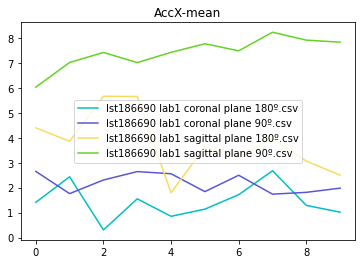

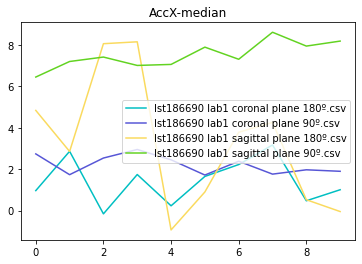

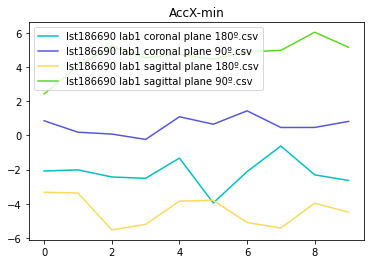

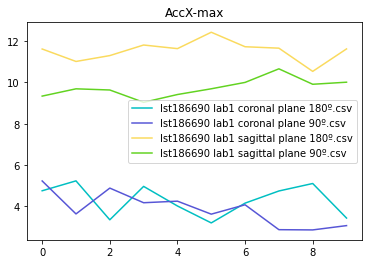

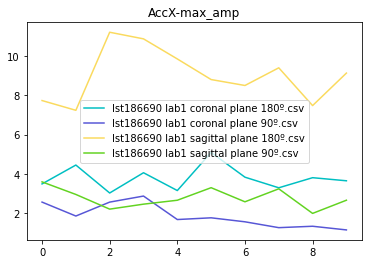

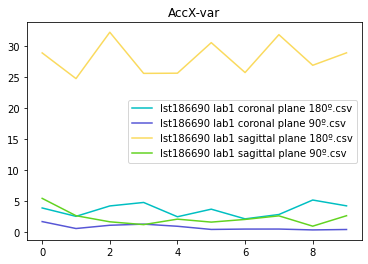

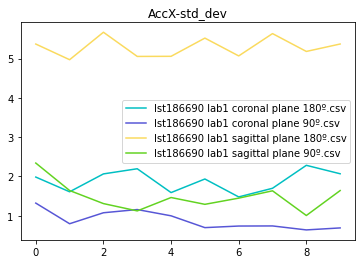

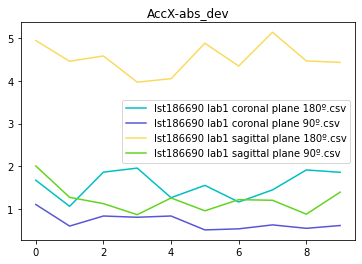

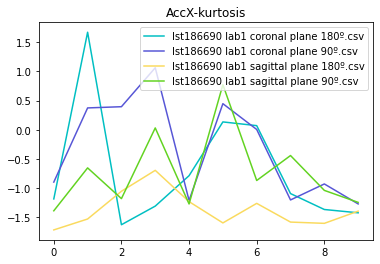

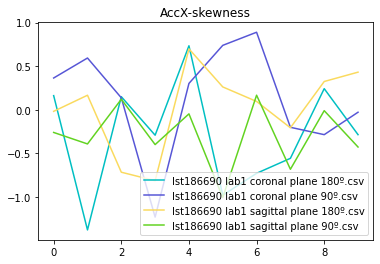

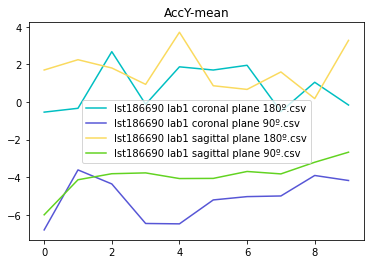

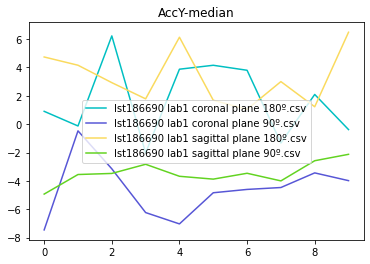

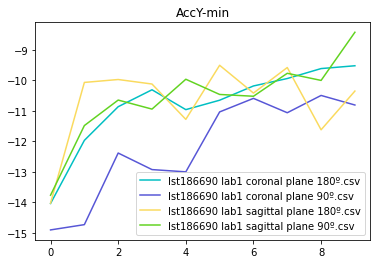

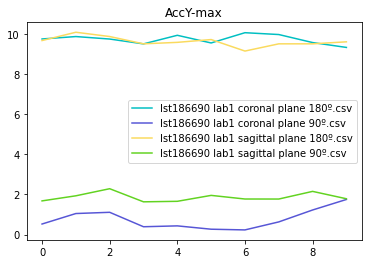

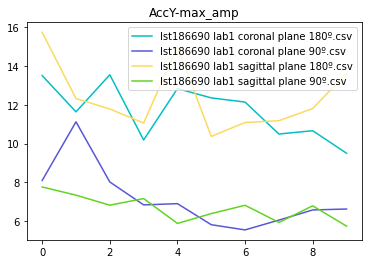

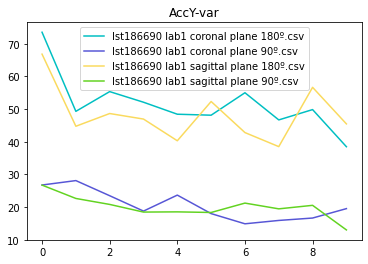

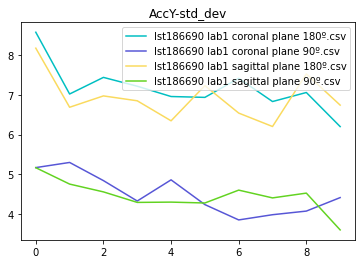

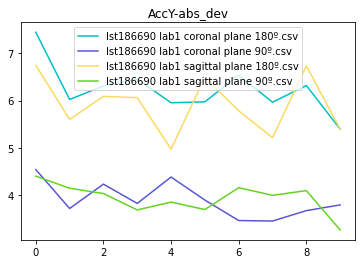

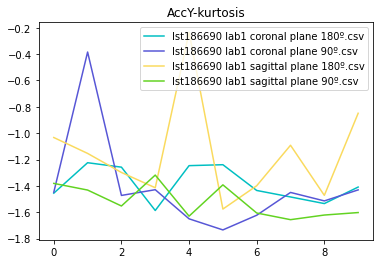

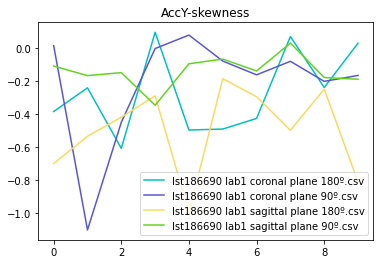

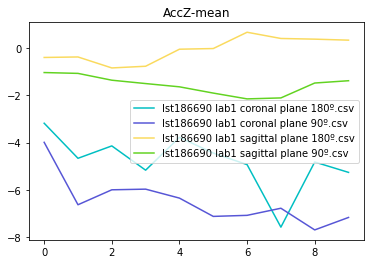

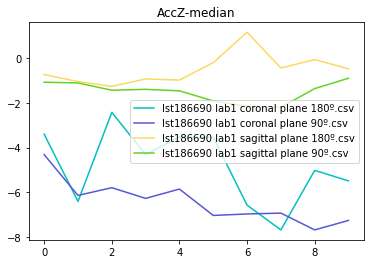

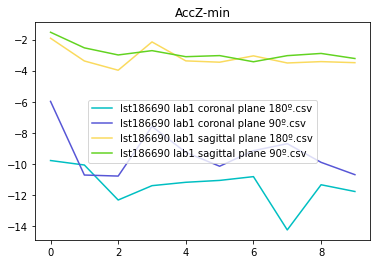

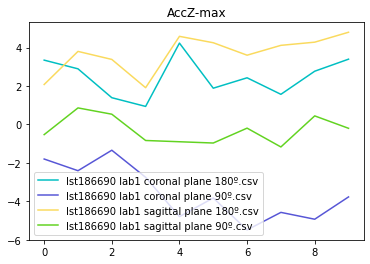

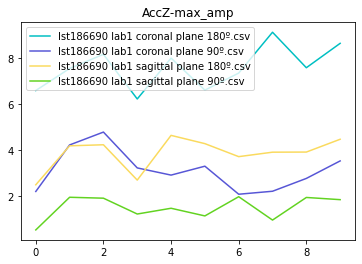

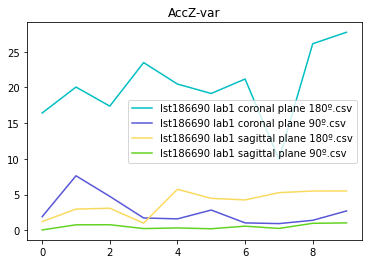

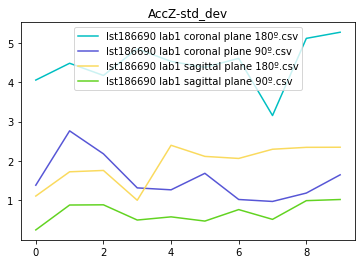

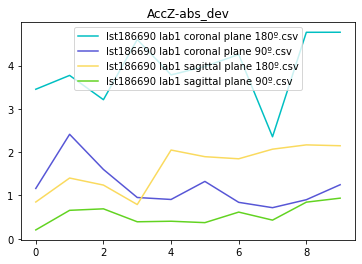

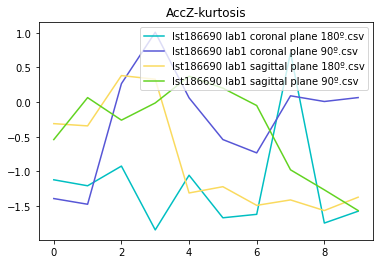

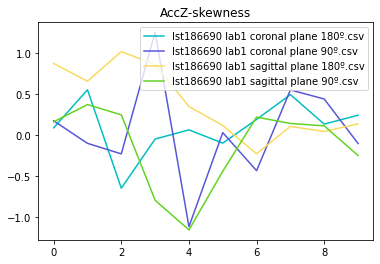

In [27]:
for feat in feats_data[act].columns:
    ci = 0
    for activity in feats_data.keys():
        plt.plot(feats_data[activity][feat], label=activity, color=colors[ci])
        ci+=1
    plt.title(feat)
    plt.legend()
    plt.show()

> 💡 **EXPLORE:** To know which features might be more appropriate, we can see which are linearly separable in the following plots. Change list best_features to those who seem to achieve the best separation.    

In [28]:
best_features = ['AccX-mean', 'AccX-max', 'AccX-std_dev', 'AccY-max', 'AccZ-max']
for act in feats_data.keys():
    feats_data[act] = feats_data[act][best_features]

## <div style="color:#484848;">   2.6. Clustering </div>

First create an X and Y joining all information from feats_data. To ease reading, we will replace the activities' names for a simpler expression 'C_180', 'C_90', 'S_180' and 'S_90'.

In [29]:
X = np.vstack([feats_data[act] for act in feats_data.keys()])
act_ = {activities_dir[1]:'C_90', activities_dir[0]: 'C_180', activities_dir[3]:'S_90', activities_dir[2]: 'S_180'}
Y = np.hstack([[act_[act]]*len(feats_data[act]) for act in feats_data.keys()])
Y

array(['C_180', 'C_180', 'C_180', 'C_180', 'C_180', 'C_180', 'C_180',
       'C_180', 'C_180', 'C_180', 'C_90', 'C_90', 'C_90', 'C_90', 'C_90',
       'C_90', 'C_90', 'C_90', 'C_90', 'C_90', 'S_180', 'S_180', 'S_180',
       'S_180', 'S_180', 'S_180', 'S_180', 'S_180', 'S_180', 'S_180',
       'S_90', 'S_90', 'S_90', 'S_90', 'S_90', 'S_90', 'S_90', 'S_90',
       'S_90', 'S_90'], dtype='<U5')

###
The proximity between groups with the same degree compared to the distance between the two different degrees hampers the separation of the 4 clusters at the same time. Thus it is more reliable to separate firstly in two big clusters and then separate again inside each cluster individually.

### <div style="color:#484848">   Hierachical Clustering - 1st layer </div>

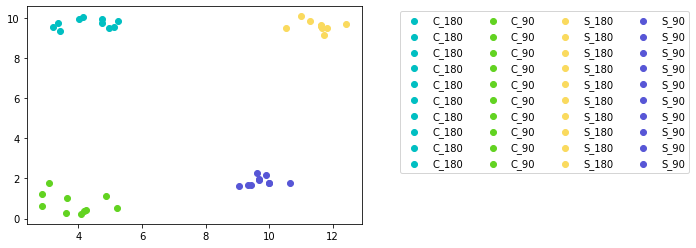

In [30]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=0)
y_pred = kmeans.fit_predict(X)

for pred in range(len(X)):
    plt.scatter(X[pred][1], X[pred][3], color=colors[y_pred[pred]], label=Y[pred])
plt.legend(bbox_to_anchor=(1.1, 1), ncol=4)
plt.show()
    

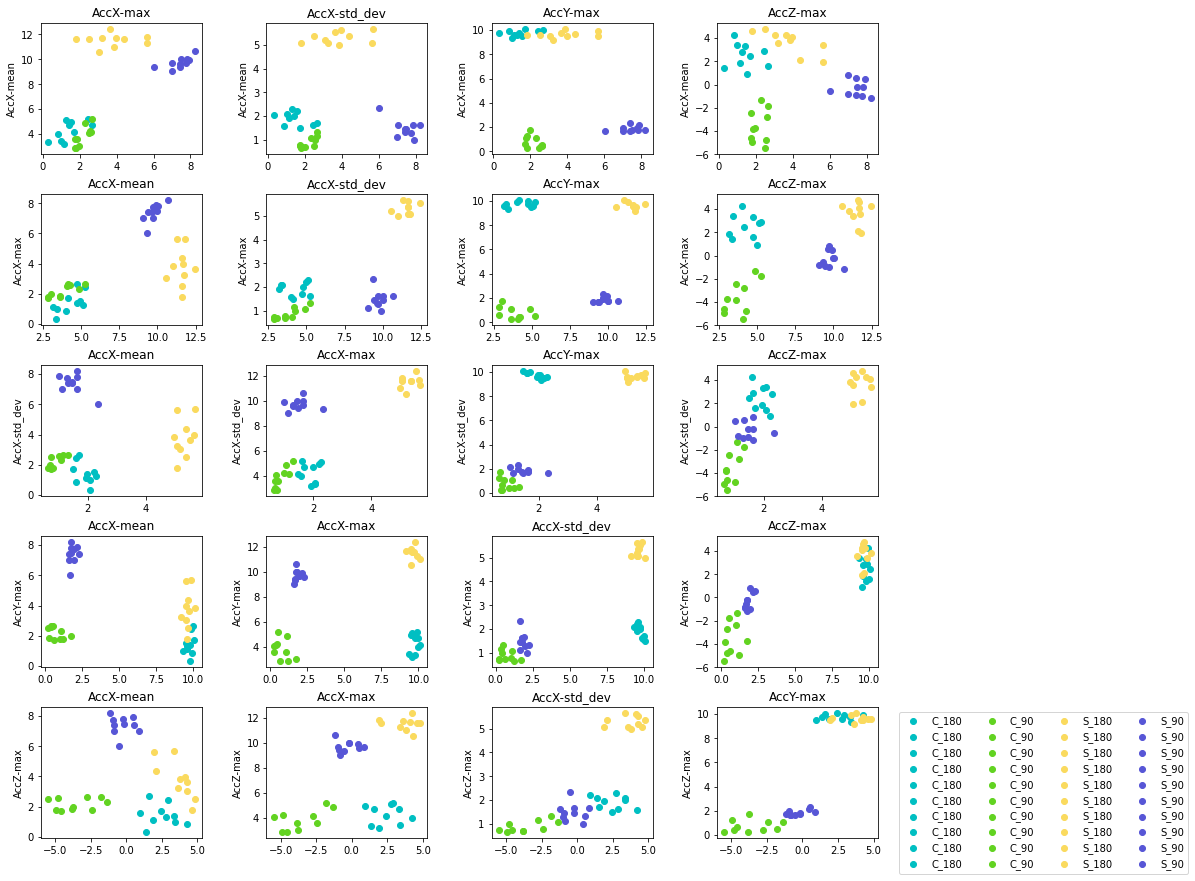

In [31]:
i=1
plt.figure(figsize=(15,15))

plt.subplots_adjust(wspace=0.4, hspace=0.3)

for bf in range(len(best_features)):
    for bi in range(len(best_features)):
        if bf != bi:
            plt.subplot(5, 4, i)
            for pred in range(len(X)):
                plt.scatter(X[pred][bf], X[pred][bi], color=colors[y_pred[pred]], label=Y[pred])
                plt.ylabel(best_features[bf])
                plt.title(best_features[bi])

            i+=1

plt.legend(bbox_to_anchor=(1.1, 1), ncol=4)
plt.show()

In [32]:
from sklearn.metrics import v_measure_score 

print('Score: ', v_measure_score(Y, y_pred))

Score:  1.0


# <span style="color:#00aba1;"> 3. Further reading </span>
Explore additional Notebooks around this and similar topics, available at [F.Machine Learning and Knowledge Extraction](https://github.com/scientisst/notebooks/tree/master/F.Machine%20Learning%20and%20Knowledge%20Extraction)

***

![scientisst-notebooks_bottom-banner](https://raw.githubusercontent.com/scientisst/notebooks/master/_Resources/bottom-banner.png)